In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/My Drive/Dissertation/envs/point_push.py" .

Mounted at /content/drive/


In [2]:
# for inference, not continued training
def save_model(model, name):
    path = f"/content/drive/My Drive/Dissertation/saved_models/point_push_random/{name}" 

    torch.save({
      'meta_controller': {
          'critic': model.meta_controller.critic.state_dict(),
          'actor': model.meta_controller.actor.state_dict(),
      },
      'controller': {
          'critic': model.controller.critic.state_dict(),
          'actor': model.controller.actor.state_dict(),
      }
    }, path)

import copy
def load_model(model, name, dir="point_push_random"):
    path = f"/content/drive/My Drive/Dissertation/saved_models/{dir}/{name}" 
    checkpoint = torch.load(path)

    model.meta_controller.critic.load_state_dict(checkpoint['meta_controller']['critic'])
    model.meta_controller.critic_target = copy.deepcopy(model.meta_controller.critic)
    model.meta_controller.actor.load_state_dict(checkpoint['meta_controller']['actor'])
    model.meta_controller.actor_target = copy.deepcopy(model.meta_controller.actor)

    model.controller.critic.load_state_dict(checkpoint['controller']['critic'])
    model.controller.critic_target = copy.deepcopy(model.controller.critic)
    model.controller.actor.load_state_dict(checkpoint['controller']['actor'])
    model.controller.actor_target = copy.deepcopy(model.controller.actor)

    # model.eval() for evaluation instead
    model.eval()
    model.meta_controller.eval()
    model.controller.eval()

In [3]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda")

In [4]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [5]:
from point_push import PointPushEnv 
env = NormalizedEnv(PointPushEnv(4))

***

In [6]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [7]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [8]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
  
# (state, action) -> (next_state, reward, done)
transition_meta = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done', 'state_seq', 'action_seq'))

# replay memory D with capacity N
class ReplayMemoryMeta(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition_meta(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

***

In [9]:
DEPTH = 128

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, DEPTH)
        self.fc2 = nn.Linear(DEPTH, DEPTH)
        self.head = nn.Linear(DEPTH, nb_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.head(x))

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(nb_states + nb_actions, DEPTH)
        self.l2 = nn.Linear(DEPTH, DEPTH)
        self.l3 = nn.Linear(DEPTH, 1)

        # Q2 architecture
        self.l4 = nn.Linear(nb_states + nb_actions, DEPTH)
        self.l5 = nn.Linear(DEPTH, DEPTH)
        self.l6 = nn.Linear(DEPTH, 1)
    
    def forward(self, state, action):
        sa = torch.cat([state, action], 1).float()

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1).float()

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

In [10]:
BATCH_SIZE = 64
GAMMA = 0.99

# https://spinningup.openai.com/en/latest/algorithms/td3.html
class TD3(nn.Module):
    def __init__(self, nb_states, nb_actions, is_meta=False):
        super(TD3, self).__init__()
        self.nb_states = nb_states
        self.nb_actions= nb_actions
        
        self.actor = Actor(self.nb_states, self.nb_actions)
        self.actor_target = Actor(self.nb_states, self.nb_actions)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=0.0001)

        self.critic = Critic(self.nb_states, self.nb_actions)
        self.critic_target = Critic(self.nb_states, self.nb_actions)
        self.critic_optimizer  = optim.Adam(self.critic.parameters(), lr=0.0001)

        hard_update(self.actor_target, self.actor)
        hard_update(self.critic_target, self.critic)
        
        self.is_meta = is_meta

        #Create replay buffer
        self.memory = ReplayMemory(100000) if not self.is_meta else ReplayMemoryMeta(100000)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.15, mu=0.0, sigma=0.2)

        # Hyper-parameters
        self.tau = 0.005
        self.depsilon = 1.0 / 20000
        self.policy_noise=0.2
        self.noise_clip=0.5
        self.policy_freq=2
        self.total_it = 0

        # 
        self.epsilon = 1.0
        self.is_training = True

    def update_policy(self, off_policy_correction=None):
        if len(self.memory) < BATCH_SIZE:
            return

        self.total_it += 1
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)

        if not self.is_meta:
            batch = transition(*zip(*transitions))
            action_batch = torch.cat(batch.action)
        else:
            batch = transition_meta(*zip(*transitions))

            action_batch = torch.cat(batch.action)
            state_seq_batch = torch.stack(batch.state_seq)
            action_seq_batch = torch.stack(batch.action_seq)

            action_batch = off_policy_correction(action_batch.cpu().numpy(), state_seq_batch.cpu().numpy(), action_seq_batch.cpu().numpy())
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)

        # Target Policy Smoothing
        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action_batch) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip).float()
            
            next_action = (
                self.actor_target(next_state_batch) + noise
            ).clamp(-1.0, 1.0).float()

            # Compute the target Q value
            # Clipped Double-Q Learning
            target_Q1, target_Q2 = self.critic_target(next_state_batch, next_action)
            target_Q = torch.min(target_Q1, target_Q2).squeeze(1)
            target_Q = (reward_batch + GAMMA * not_done_mask  * target_Q).float()
        
        # Critic update
        current_Q1, current_Q2 = self.critic(state_batch, action_batch)
      
        critic_loss = F.mse_loss(current_Q1, target_Q.unsqueeze(1)) + F.mse_loss(current_Q2, target_Q.unsqueeze(1))

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:
            # Compute actor loss
            actor_loss = -self.critic.Q1(state_batch, self.actor(state_batch)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # print losses
            #if self.total_it % (50 * 50 if self.is_meta else 500 * 50) == 0:
            #    print(f"{self.is_meta} controller;\n\tcritic loss: {critic_loss.item()}\n\tactor loss: {actor_loss.item()}")

            # Target update
            soft_update(self.actor_target, self.actor, self.tau)
            soft_update(self.critic_target, self.critic, 2 * self.tau / 5)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def observe(self, s_t, a_t, s_t1, r_t, done):
        self.memory.store(s_t, a_t, s_t1, r_t, done)

    def random_action(self):
        return torch.tensor([np.random.uniform(-1.,1.,self.nb_actions)], device=device, dtype=torch.float)

    def select_action(self, s_t, warmup, decay_epsilon):
        if warmup:
            return self.random_action()

        with torch.no_grad():
            action = self.actor(s_t).squeeze(0)
            #action += torch.from_numpy(self.is_training * max(self.epsilon, 0) * self.random_process.sample()).to(device).float()
            action += torch.from_numpy(self.is_training * max(self.epsilon, 0) * np.random.uniform(-1.,1.,1)).to(device).float()
            action = torch.clamp(action, -1., 1.)

            action = action.unsqueeze(0)
            
            if decay_epsilon:
                self.epsilon -= self.depsilon
            
            return action

In [11]:
class HIRO(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(HIRO, self).__init__()
        self.nb_states = nb_states
        self.nb_actions= nb_actions
        self.goal_dim = [0, 1]
        self.goal_dimen = 2
      
        self.meta_controller = TD3(nb_states, len(self.goal_dim), True).to(device)
        self.max_goal_dist = torch.from_numpy(np.array([2.5, 2.5])).to(device)
        self.goal_offset = torch.from_numpy(np.array([0., 1.])).to(device)
        #self.meta_controller.depsilon = 1.0 / 10000

        self.controller = TD3(nb_states + len(self.goal_dim), nb_actions).to(device)
        #self.controller.depsilon = 1.0 / 10000

    def teach_controller(self):
        self.controller.update_policy()
    def teach_meta_controller(self):
        self.meta_controller.update_policy(self.off_policy_corrections)

    def h(self, state, goal, next_state):
        #return goal
        return state[:,self.goal_dim] + goal - next_state[:,self.goal_dim]
    #def intrinsic_reward(self, action, goal):
    #    return torch.tensor(1.0 if self.goal_reached(action, goal) else 0.0, device=device) 
    #def goal_reached(self, action, goal, threshold = 0.1):
    #    return torch.abs(action - goal) <= threshold
    def intrinsic_reward(self, reward, state, goal, next_state):
        #return torch.tensor(2 * reward if self.goal_reached(state, goal, next_state) else reward / 10, device=device) #reward / 2
        # just L2 norm
        return -torch.pow(sum(torch.pow(state.squeeze(0)[self.goal_dim] + goal.squeeze(0) - next_state.squeeze(0)[self.goal_dim], 2)), 0.5)
    def goal_reached(self, state, goal, next_state, threshold = 0.1):
        return torch.pow(sum(torch.pow(state.squeeze(0)[self.goal_dim] + goal.squeeze(0) - next_state.squeeze(0)[self.goal_dim], 2)), 0.5) <= threshold
        #return torch.pow(sum(goal.squeeze(0), 2), 0.5) <= threshold

    # correct goals to allow for use in experience replay
    def off_policy_corrections(self, sgoals, states, actions, candidate_goals=8):
        first_s = [s[0] for s in states] # First x
        last_s = [s[-1] for s in states] # Last x

        # Shape: (batch_size, 1, subgoal_dim)
        # diff = 1
        diff_goal = (np.array(last_s) - np.array(first_s))[:, np.newaxis, :self.goal_dimen]

        # Shape: (batch_size, 1, subgoal_dim)
        # original = 1
        # random = candidate_goals
        scale = self.max_goal_dist.cpu().numpy()
        original_goal = np.array(sgoals)[:, np.newaxis, :]
        random_goals = np.random.normal(loc=diff_goal, scale=.5*scale,
                                        size=(BATCH_SIZE, candidate_goals, original_goal.shape[-1]))
        random_goals = random_goals.clip(-scale, scale)

        # Shape: (batch_size, 10, subgoal_dim)
        candidates = np.concatenate([original_goal, diff_goal, random_goals], axis=1)
        #states = np.array(states)[:, :-1, :]
        actions = np.array(actions)
        seq_len = len(states[0])

        # For ease
        new_batch_sz = seq_len * BATCH_SIZE
        action_dim = actions[0][0].shape
        obs_dim = states[0][0].shape
        ncands = candidates.shape[1]

        true_actions = actions.reshape((new_batch_sz,) + action_dim)
        observations = states.reshape((new_batch_sz,) + obs_dim)
        goal_shape = (new_batch_sz, self.goal_dimen)
        # observations = get_obs_tensor(observations, sg_corrections=True)

        # batched_candidates = np.tile(candidates, [seq_len, 1, 1])
        # batched_candidates = batched_candidates.transpose(1, 0, 2)

        policy_actions = np.zeros((ncands, new_batch_sz) + action_dim)

        observations = torch.from_numpy(observations).to(device)
        for c in range(ncands):
            subgoal = candidates[:,c]
            candidate = (subgoal + states[:, 0, :self.goal_dimen])[:, None] - states[:, :, :self.goal_dimen]
            candidate = candidate.reshape(*goal_shape)
            policy_actions[c] = self.controller.actor(torch.cat([observations, torch.from_numpy(candidate).to(device)], 1).float()).detach().cpu().numpy()

        difference = (policy_actions - true_actions)
        difference = np.where(difference != -np.inf, difference, 0)
        difference = difference.reshape((ncands, BATCH_SIZE, seq_len) + action_dim).transpose(1, 0, 2, 3)

        logprob = -0.5*np.sum(np.linalg.norm(difference, axis=-1)**2, axis=-1)
        max_indices = np.argmax(logprob, axis=-1)

        return torch.from_numpy(candidates[np.arange(BATCH_SIZE), max_indices]).to(device).float()

    def observe_controller(self, s_t, a_t, s_t1, r_t, done):
        self.controller.memory.store(s_t, a_t, s_t1, r_t, done)
    def observe_meta_controller(self, s_t, a_t, s_t1, r_t, done, state_seq, action_seq):
        self.meta_controller.memory.store(s_t, a_t, s_t1, r_t, done, state_seq, action_seq)

    def select_goal(self, s_t, warmup, decay_epsilon):
        return self.meta_controller.select_action(s_t, warmup, decay_epsilon) * self.max_goal_dist + self.goal_offset
    def select_action(self, s_t, g_t, warmup, decay_epsilon):
        sg_t = torch.cat([s_t, g_t], 1).float()
        return self.controller.select_action(sg_t, warmup, decay_epsilon)

In [ ]:
import time
SAVE_OFFSET = 7
def train_model():
    global SAVE_OFFSET
    n_observations = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    
    agent = HIRO(n_observations, n_actions).to(device)
    
    max_episode_length = 500
    observation = None
    
    warmup = 100
    num_episodes = 10000 # M
    episode_durations = []
    goal_durations = []

    steps = 0
    c = 10

    for i_episode in range(num_episodes):
        observation = env.reset()
        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        
        overall_reward = 0
        overall_intrinsic = 0
        episode_steps = 0
        done = False
        goals_done = 0

        while not done:
            # random goal
            goal = agent.select_goal(state, True, False)
            #goal_durations.append((steps, goal[:,0]))

            state_seq, action_seq = None, None
            first_goal = goal
            goal_done = False
            total_extrinsic = 0

            while not done and not goal_done:
                joint_goal_state = torch.cat([state, goal], axis=1).float()

                # agent pick action ...
                action = agent.select_action(state, goal, i_episode <= warmup, True)
                
                # env response with next_observation, reward, terminate_info
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                steps += 1
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                next_goal = agent.h(state, goal, next_state)
                joint_next_state = torch.cat([next_state, next_goal], axis=1).float()
                
                if max_episode_length and episode_steps >= max_episode_length -1:
                    done = True
                    
                extrinsic_reward = torch.tensor([reward], device=device)
                intrinsic_reward = agent.intrinsic_reward(reward, state, goal, next_state).unsqueeze(0)
                #intrinsic_reward = agent.intrinsic_reward(action, goal).unsqueeze(0)

                overall_reward += reward
                total_extrinsic += reward
                overall_intrinsic += intrinsic_reward

                goal_reached = agent.goal_reached(state, goal, next_state)
                #goal_done = agent.goal_reached(action, goal)

                # agent observe and update policy
                agent.observe_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done) #goal_done.item())

                if state_seq is None:
                    state_seq = state
                else:
                    state_seq = torch.cat([state_seq, state])
                if action_seq is None:
                    action_seq = action
                else:
                    action_seq = torch.cat([action_seq, action])

                episode_steps += 1

                if goal_reached:
                    goals_done += 1
                
                if (episode_steps % c) == 0:
                    agent.observe_meta_controller(state_seq[0].unsqueeze(0), goal, next_state, torch.tensor([total_extrinsic], device=device), done,\
                                                  state_seq, action_seq)
                    goal_done = True

                    #if i_episode > warmup:
                    #    agent.teach_meta_controller()

                state = next_state
                goal = next_goal
                
                if i_episode > warmup:
                    agent.teach_controller()

        goal_durations.append((i_episode, overall_intrinsic / episode_steps))
        episode_durations.append((i_episode, overall_reward))
        #plot_durations(episode_durations, goal_durations)

        _, dur = list(map(list, zip(*episode_durations)))
        if len(dur) > 100:
            if i_episode % 100 == 0:
                print(f"{i_episode}: {np.mean(dur[-100:])}")
            if i_episode >= 300 and i_episode % 100 == 0 and np.mean(dur[-100:]) <= -49.0:
                print(f"Unlucky after {i_episode} eps! Terminating...")
                return None
            if np.mean(dur[-100:]) >= 90:
                print(f"Solved after {i_episode} episodes!")
                save_model(agent, f"hiro_{SAVE_OFFSET}")
                SAVE_OFFSET += 1
                return agent

    return None # did not train

In [ ]:
state_max = torch.from_numpy(env.observation_space.high).to(device).float()
state_min = torch.from_numpy(env.observation_space.low).to(device).float()
state_mid = (state_max + state_min) / 2.
state_range = (state_max - state_min)
def eval_model(agent, episode_durations, goal_attack, action_attack, same_noise):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for l2norm in np.arange(0.0,0.51,0.05):
        
        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)

            if goal_attack:
                g_state = g_state + state_range * noise
                g_state = torch.max(torch.min(g_state, state_max), state_min).float()
            if action_attack:
                if same_noise:
                    state = state + state_range * noise
                else:
                    state = state + state_range * torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
                state = torch.max(torch.min(state, state_max), state_min).float()

            episode_steps = 0
            done = False
            while not done:
                # select a goal
                goal = agent.select_goal(g_state, True, False)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                    
                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                    noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
                    if goal_attack:
                        g_next_state = g_next_state + state_range * noise
                        g_next_state = torch.max(torch.min(g_next_state, state_max), state_min).float()
                    if action_attack:
                        if same_noise:
                            next_state = next_state + state_range * noise
                        else:
                            next_state = next_state + state_range * torch.FloatTensor(next_state.shape).uniform_(-l2norm, l2norm).to(device)
                        next_state = torch.max(torch.min(next_state, state_max), state_min).float()

                    next_goal = agent.h(g_state, goal, g_next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    g_state = g_next_state
                    goal = next_goal

        episode_durations[np.round(l2norm, 2)].append(overall_reward / num_episodes)

In [ ]:
state_max = torch.from_numpy(env.observation_space.high).to(device).float()
state_min = torch.from_numpy(env.observation_space.low).to(device).float()
state_mid = (state_max + state_min) / 2.
state_range = (state_max - state_min)
def fgsm_attack(data, eps, data_grad):
    sign_data_grad = data_grad.sign()

    perturbed_data = data + eps * sign_data_grad * state_range

    clipped_perturbed_data = torch.max(torch.min(perturbed_data, state_max), state_min)

    return clipped_perturbed_data

def fgsm_action(state, goal, agent, eps, target, targeted):
    #state = torch.tensor(state, requires_grad=True)
    state = state.clone().detach().requires_grad_(True)
    goal = goal.clone().detach()

    sg_t = torch.cat([state, goal], 1).float()

    if targeted:
        # initial forward pass
        action = agent.controller.actor(sg_t)
        action = torch.clamp(action, -1., 1.)

        loss = F.mse_loss(action, target)
    else:
        loss = agent.controller.critic.Q1(sg_t, agent.controller.actor(sg_t)).mean()

    agent.controller.actor.zero_grad()

    # calc loss
    loss.backward()
    data_grad = state.grad.data
    # perturb state
    state_p = fgsm_attack(state, eps, data_grad).float()
    return state_p

def apply_fgsm(agent, episode_durations, targeted):
    TARGET_ACTION = torch.tensor([[0.0, 0.0]], device=device, dtype=torch.float)

    agent.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for eps in np.arange(0.0, 0.201, 0.02):

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            og_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            goal = agent.select_goal(og_state, True, False)
            state = fgsm_action(og_state, goal, agent, eps, TARGET_ACTION, targeted)

            episode_steps = 0
            done = False
            while not done:
                goal = agent.select_goal(state, True, False)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

                    next_og_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    goal_temp = agent.h(state, goal, next_og_state)
                    next_state = fgsm_action(next_og_state, goal_temp, agent, eps, TARGET_ACTION, targeted)

                    next_goal = agent.h(state, goal, next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(state, goal, next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    goal = next_goal

        episode_durations[eps].append(overall_reward / num_episodes)

In [ ]:
noise_hrl = {'both': {}, 'action_only': {}, 'goal_only': {}, 'both_same': {}}
for l2norm in np.arange(0,0.51,0.05):
    for i in [noise_hrl['both'], noise_hrl['action_only'], noise_hrl['goal_only'], noise_hrl['both_same']]:
        i[np.round(l2norm, 2)] = []

targeted = {'both': {}, 'goal_only': {}, 'action_only': {}}
untargeted = {'both': {}, 'goal_only': {}, 'action_only': {}}
for eps in np.arange(0.0, 0.201, 0.02):
    for x in ['both', 'goal_only', 'action_only']:
        targeted[x][eps] = []
        untargeted[x][eps] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 2
while i < 6:
    agent = train_model()
    #agent = HIRO(n_observations, n_actions).to(device)
    #load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        eval_model(agent, noise_hrl['both_same'], True, True, True)
        eval_model(agent, noise_hrl['both'], True, True, False)
        eval_model(agent, noise_hrl['action_only'], False, True, False)
        eval_model(agent, noise_hrl['goal_only'], True, False, False)
        print(f"{i} noise_hrl: {noise_hrl}")
        i += 1

print("----")
print(f"noise_hrl: {noise_hrl}")

100: -44.042000000000414
200: -38.048000000000414
300: -27.782000000000384
400: -18.841000000000374
500: -23.39300000000038
600: -27.85200000000038
700: -30.70600000000039
800: -14.352000000000348
900: -20.551000000000364
1000: -16.107000000000344
1100: -15.276000000000334
1200: -1.5050000000002928
1300: -8.125000000000316
1400: -13.261000000000323
1500: -25.62500000000037
1600: -35.1160000000004
1700: -19.616000000000348
1800: -24.330000000000364
1900: -14.251000000000335
2000: 4.38999999999973
2100: -6.332000000000306
2200: -16.645000000000344
2300: -12.915000000000326
2400: -28.65100000000038
2500: -29.84800000000038
2600: -21.20100000000036
2700: -7.790000000000313
2800: -8.796000000000321
2900: -5.451000000000303
3000: -9.923000000000318
3100: -0.5610000000002989
3200: -6.180000000000314
3300: 0.7049999999997172
3400: 11.46699999999975
3500: 13.802999999999745
3600: 10.185999999999751
3700: 19.538999999999778
3800: 29.23899999999979
3900: 12.867999999999746
4000: 10.57399999999974

KeyboardInterrupt: ignored

In [ ]:
Solved after 8608 episodes!
Solved after 7321 episodes!
1 noise_hrl: {'both': {0.0: [86.3469999999895, 87.65399999998935], 0.05: [55.524999999985376, 74.7739999999933], 0.1: [24.802000000008366, 55.677000000000916], 0.15: [-1.874000000001195, 58.548999999982826], 0.2: [-26.797999999980362, 56.17599999999996], 0.25: [-27.88699999998136, 22.825000000012075], 0.3: [-35.85899999996834, 29.907000000016346], 0.35: [-28.625999999977736, 16.396000000008303], 0.4: [-38.03599999996919, -5.017000000005212], 0.45: [-33.44099999997778, -9.225000000006728], 0.5: [-38.69199999996758, -21.327999999988982]}, 'action_only': {0.0: [79.6429999999958, 94.0169999999898], 0.05: [61.07699999998948, 70.41599999999465], 0.1: [17.214000000005058, 57.116999999985964], 0.15: [-9.359000000004709, 60.63999999998295], 0.2: [-19.129999999992027, 55.055999999994555], 0.25: [-27.182999999975063, 33.216000000015825], 0.3: [-29.666999999980558, 26.390000000018247], 0.35: [-40.639999999969625, 7.551999999994045], 0.4: [-34.6259999999731, 1.4060000000002901], 0.45: [-40.4169999999701, -3.8350000000067213], 0.5: [-38.426999999971706, -15.964999999984284]}, 'goal_only': {0.0: [85.49999999998208, 90.27299999998779], 0.05: [73.7489999999876, 86.13199999998803], 0.1: [90.36599999998974, 94.00499999999145], 0.15: [79.74099999998283, 88.13899999998452], 0.2: [83.35299999999079, 86.9519999999878], 0.25: [91.39099999998592, 75.3839999999887], 0.3: [93.32899999998921, 85.58099999999193], 0.35: [88.41699999999129, 82.73099999998767], 0.4: [94.34699999999287, 75.23299999999354], 0.45: [90.43399999998728, 69.14999999998544], 0.5: [76.46999999999348, 76.51199999999781]}, 'both_same': {0.0: [79.26799999998829, 88.93599999998618], 0.05: [65.02099999999031, 79.44799999998877], 0.1: [30.39500000000683, 60.743999999989825], 0.15: [-9.751000000007506, 62.986999999985464], 0.2: [-19.30999999998804, 44.62099999998817], 0.25: [-26.904999999973917, 37.94800000001537], 0.3: [-36.647999999968626, 16.14300000001135], 0.35: [-22.282999999974464, 15.069000000016723], 0.4: [-32.69299999997167, -6.546000000001744], 0.45: [-38.29099999997223, -8.963999999998231], 0.5: [-32.8609999999713, -8.572000000001363]}}
Solved after 8525 episodes!
Solved after 7558 episodes!
Solved after 9907 episodes!
4 noise_hrl: {'both': {0.0: [84.39799999998418, 91.60399999999292, 89.26899999998801], 0.05: [81.24299999998449, 63.81999999998437, 87.1229999999881], 0.1: [46.06900000000408, 33.979000000011816, 48.29699999999753], 0.15: [13.369000000000169, -5.725000000002775, 29.801000000006514], 0.2: [-10.648999999998377, -27.662999999977302, 4.829999999999236], 0.25: [-17.678999999987738, -20.92799999998064, -9.39600000000651], 0.3: [-20.908999999990577, -20.545999999982314, 1.8349999999951092], 0.35: [-20.208999999985984, -35.75499999997244, -4.661000000002129], 0.4: [-25.34099999997451, -26.208999999979678, -19.08299999999252], 0.45: [-30.237999999972754, -23.830999999984925, -8.775000000005582], 0.5: [-33.726999999971355, -40.25199999997113, -28.36499999998271]}, 'action_only': {0.0: [86.16799999998634, 89.44599999998574, 89.33399999999011], 0.05: [73.67299999998892, 65.41999999998957, 79.8419999999934], 0.1: [56.122999999992565, 16.78699999999977, 46.66900000000867], 0.15: [10.931000000016843, -5.5000000000030855, 27.628000000015273], 0.2: [-9.454000000002548, -26.497999999983094, 9.278999999996678], 0.25: [-14.475999999993476, -27.526999999975914, 3.811999999995667], 0.3: [-25.45199999998025, -27.567999999981854, -5.046000000006478], 0.35: [-31.010999999973656, -26.352999999972408, -7.0920000000031225], 0.4: [-24.91999999997124, -27.19699999998373, -6.97800000000537], 0.45: [-29.95299999997211, -23.658999999982566, -7.250000000003798], 0.5: [-32.359999999975926, -29.46599999997592, -14.10699999999513]}, 'goal_only': {0.0: [87.6469999999883, 90.82399999999171, 93.744999999995], 0.05: [91.30799999999286, 95.12799999999211, 88.49999999999314], 0.1: [86.96999999998779, 96.89199999999455, 91.86199999999143], 0.15: [77.02799999998477, 92.26399999998962, 96.2089999999954], 0.2: [88.67399999998693, 88.262999999986, 89.1079999999946], 0.25: [85.80399999998794, 73.80099999998896, 93.47599999999574], 0.3: [79.82499999999318, 84.04999999998958, 92.00799999999109], 0.35: [85.83899999998896, 83.68399999998181, 93.53999999999348], 0.4: [82.58499999998689, 75.28999999999246, 85.93599999999105], 0.45: [73.90899999999519, 73.23599999998838, 83.16799999999648], 0.5: [75.28099999998858, 76.72299999998471, 90.52399999999139]}, 'both_same': {0.0: [84.55599999998685, 92.08999999999008, 92.05499999998777], 0.05: [66.33999999999033, 52.67099999999499, 76.95199999998873], 0.1: [50.61099999998198, 21.270000000015894, 49.21399999998093], 0.15: [33.915000000012874, -16.097999999999498, 39.41400000001159], 0.2: [2.9809999999990064, -27.500999999983897, 20.0410000000179], 0.25: [-17.112999999980925, -22.356999999981568, 10.370000000017317], 0.3: [-28.638999999981007, -28.23399999997186, 4.966000000003962], 0.35: [-29.027999999979098, -24.964999999981796, -2.8960000000058455], 0.4: [-27.97499999997789, -24.17699999998227, -0.023000000006989985], 0.45: [-36.01499999997246, -30.09699999997815, -9.765999999988287], 0.5: [-36.41299999996897, -33.76599999997054, -14.336999999996248]}}
...
Solved after 9584 episodes!
Solved after 8327 episodes!
6 noise_hrl: {'both': {0.0: [88.74599999998608, 82.8799999999944], 0.05: [41.05300000000923, 29.047000000017405], 0.1: [22.91600000001603, 23.634000000015444], 0.15: [-2.393000000003058, 15.102000000003233], 0.2: [-15.586999999986508, 6.132999999996659], 0.25: [-23.793999999983075, -9.679000000005368], 0.3: [-25.64999999997912, -20.640999999977566], 0.35: [-30.269999999973102, -25.930999999988153], 0.4: [-31.572999999975192, -20.195999999984856], 0.45: [-33.13399999997293, -29.55499999997742], 0.5: [-32.52299999997181, -21.92599999997624]}, 'action_only': {0.0: [85.35299999999093, 80.03899999998228], 0.05: [35.81100000001877, 32.036000000015875], 0.1: [7.328999999997956, 27.08700000001365], 0.15: [-6.937000000006416, 14.70000000000065], 0.2: [-23.018999999982128, -4.39200000000317], 0.25: [-26.143999999972852, -9.280000000004925], 0.3: [-15.495999999986859, -12.578999999991717], 0.35: [-14.878999999990691, -23.083999999981415], 0.4: [-23.958999999976573, -18.15899999997716], 0.45: [-40.337999999970236, -20.479999999989044], 0.5: [-37.4899999999682, -20.309999999987678]}, 'goal_only': {0.0: [88.5589999999948, 76.8569999999862], 0.05: [91.12199999998634, 86.38599999999033], 0.1: [93.16699999998929, 83.09399999998537], 0.15: [92.15199999999291, 79.9049999999913], 0.2: [87.40299999998467, 81.41399999998505], 0.25: [90.52799999998905, 68.79999999997658], 0.3: [84.34499999999312, 72.6959999999797], 0.35: [84.58599999998464, 71.1739999999851], 0.4: [91.74999999999517, 73.50499999999285], 0.45: [89.57099999999318, 68.29699999999609], 0.5: [84.93699999998427, 62.84499999999364]}, 'both_same': {0.0: [88.02199999998318, 71.5009999999796], 0.05: [50.38699999999266, 17.033000000007473], 0.1: [8.824000000003691, 6.6549999999985445], 0.15: [-6.045000000004539, 14.105000000000341], 0.2: [-14.559999999982583, -4.93200000000467], 0.25: [-23.125999999976575, -8.962000000004327], 0.3: [-34.607999999974524, -15.90099999998204], 0.35: [-33.547999999973314, -15.44899999999859], 0.4: [-32.10699999997676, -19.078999999984436], 0.45: [-31.193999999974068, -15.150999999991019], 0.5: [-35.047999999971346, -32.65699999997801]}}

In [ ]:
targeted = {'goal': {}, 'action': {}}
untargeted = {'goal': {}, 'action': {}}
for eps in np.arange(0.0, 0.201, 0.02):
    for x in ['goal', 'action']:
        targeted[x][eps] = []
        untargeted[x][eps] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 0
while i < 7:
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_{i}")

    if agent is not None:
        apply_fgsm(agent, untargeted['action'], False)   
        print(f"{i} fgsm (ut): {untargeted}")

        apply_fgsm(agent, targeted['action'], True)   
        print(f"{i} fgsm (t): {targeted}")
        i += 1

print("----")
print(f"fgsm (ut): {untargeted}")
print(f"fgsm (t): {targeted}")

0 fgsm (ut): {'goal': {0.0: [], 0.02: [], 0.04: [], 0.06: [], 0.08: [], 0.1: [], 0.12: [], 0.14: [], 0.16: [], 0.18: [], 0.2: []}, 'action': {0.0: [82.87999999998944], 0.02: [23.447000000012828], 0.04: [-19.637999999989162], 0.06: [-31.40499999997273], 0.08: [-39.537999999970914], 0.1: [-44.25499999998204], 0.12: [-47.54600000000038], 0.14: [-39.11599999996947], 0.16: [-43.18899999997968], 0.18: [-48.90400000000169], 0.2: [-43.070999999977055]}}
0 fgsm (t): {'goal': {0.0: [], 0.02: [], 0.04: [], 0.06: [], 0.08: [], 0.1: [], 0.12: [], 0.14: [], 0.16: [], 0.18: [], 0.2: []}, 'action': {0.0: [79.21899999999], 0.02: [70.7049999999916], 0.04: [54.36999999999334], 0.06: [20.67700000001389], 0.08: [-10.994000000001629], 0.1: [-23.623999999975545], 0.12: [-27.37599999997537], 0.14: [-34.46299999997086], 0.16: [-28.70299999997426], 0.18: [-38.80299999997152], 0.2: [-45.982999999995265]}}
1 fgsm (ut): {'goal': {0.0: [], 0.02: [], 0.04: [], 0.06: [], 0.08: [], 0.1: [], 0.12: [], 0.14: [], 0.16: [

In [12]:
def eval_scale(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for scale in np.arange(1.0,7.01,0.5):
        env = NormalizedEnv(PointPushEnv(scale))

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            episode_steps = 0
            done = False
            while not done:
                # select a goal
                goal = agent.select_goal(g_state, True, False)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                    
                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                    next_goal = agent.h(g_state, goal, g_next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    g_state = g_next_state
                    goal = next_goal

        episode_durations[np.round(scale, 2)].append(overall_reward / num_episodes)

In [13]:
episodes = {}
for scale in np.arange(1.0,7.01,0.5):
    episodes[np.round(scale, 2)] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 0
while i < 7:
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        eval_scale(agent, episodes)
        print(f"{i} scale: {episodes}")
        i += 1

print("----")
print(f"scale: {episodes}")

0 scale: {1.0: [8.311999999995733], 1.5: [8.463999999997394], 2.0: [37.05800000001532], 2.5: [41.425000000012176], 3.0: [71.9749999999868], 3.5: [81.74699999999113], 4.0: [83.85999999998506], 4.5: [74.47799999999648], 5.0: [89.55799999999176], 5.5: [84.67499999998314], 6.0: [84.96299999998129], 6.5: [78.30199999998203], 7.0: [71.70199999998422]}
1 scale: {1.0: [8.311999999995733, -34.695999999973466], 1.5: [8.463999999997394, -2.3850000000050775], 2.0: [37.05800000001532, 84.14599999999155], 2.5: [41.425000000012176, 89.92199999999156], 3.0: [71.9749999999868, 94.20299999999418], 3.5: [81.74699999999113, 92.73299999999094], 4.0: [83.85999999998506, 90.29699999999053], 4.5: [74.47799999999648, 87.62099999998861], 5.0: [89.55799999999176, 80.01399999998684], 5.5: [84.67499999998314, 80.4539999999833], 6.0: [84.96299999998129, 76.06499999998928], 6.5: [78.30199999998203, 84.98199999998687], 7.0: [71.70199999998422, 72.30399999998355]}
2 scale: {1.0: [8.311999999995733, -34.695999999973466

In [14]:
def eval_starting_position(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for extra_range in np.arange(0.0, 0.401, 0.05):
        
        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            extra = np.random.uniform(-0.1 - extra_range, 0.1 + extra_range, env.starting_point.shape)
            #extra = np.random.uniform(0.1, 0.1 + extra_range, env.starting_point.shape)
            #extra = extra * (2*np.random.randint(0,2,size=env.starting_point.shape)-1)
            env.unwrapped.state = np.array(env.starting_point + extra, dtype=np.float32)
            env.unwrapped.state[2] += math.pi / 2. # start facing up
            env.unwrapped.state[2] = env.state[2] % (2 * math.pi)
            observation = env.normalised_state()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            episode_steps = 0
            done = False
            while not done:
                # select a goal
                goal = agent.select_goal(g_state, True, False)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                    
                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                    next_goal = agent.h(g_state, goal, g_next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    g_state = g_next_state
                    goal = next_goal

        episode_durations[np.round(extra_range, 3)].append(overall_reward / num_episodes)

In [15]:
episodes = {}
for extra_range in np.arange(0.0, 0.401, 0.05):
    episodes[np.round(extra_range, 3)] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

env = NormalizedEnv(PointPushEnv(4))
i = 0
while i < 7:
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        eval_starting_position(agent, episodes)
        print(f"{i} range: {episodes}")
        i += 1

print("----")
print(f"range: {episodes}")

0 range: {0.0: [85.04899999998874], 0.05: [77.76299999998585], 0.1: [77.93999999998756], 0.15: [66.57199999999374], 0.2: [54.99799999999712], 0.25: [70.42100000000063], 0.3: [54.90199999998741], 0.35: [50.533000000004535], 0.4: [57.31599999998752]}
1 range: {0.0: [85.04899999998874, 86.22499999998706], 0.05: [77.76299999998585, 90.06999999998408], 0.1: [77.93999999998756, 86.28199999998846], 0.15: [66.57199999999374, 82.01399999997837], 0.2: [54.99799999999712, 75.09299999998919], 0.25: [70.42100000000063, 70.28999999998335], 0.3: [54.90199999998741, 52.96599999999454], 0.35: [50.533000000004535, 40.31400000001508], 0.4: [57.31599999998752, 36.1020000000172]}
2 range: {0.0: [85.04899999998874, 86.22499999998706, 87.45999999998735], 0.05: [77.76299999998585, 90.06999999998408, 83.24899999998479], 0.1: [77.93999999998756, 86.28199999998846, 71.34899999999273], 0.15: [66.57199999999374, 82.01399999997837, 75.57699999999028], 0.2: [54.99799999999712, 75.09299999998919, 59.62099999998479], 

In [ ]:
state_max = torch.from_numpy(env.observation_space.high).to(device).float()
state_min = torch.from_numpy(env.observation_space.low).to(device).float()
state_mid = (state_max + state_min) / 2.
state_range = (state_max - state_min)
def save_trajectories(agent, episode_durations, dirty):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 10

    c = 10

    l2norm = 0.3
    episode_durations.append([])
    
    for i_episode in range(num_episodes):
        path = {"overall_reward": 0, "manager": [], "worker": []}

        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        g_state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)

        if dirty:
            g_state = g_state + state_range * noise
            g_state = torch.max(torch.min(g_state, state_max), state_min).float()
        if dirty:
            state = state + state_range * torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
            state = torch.max(torch.min(state, state_max), state_min).float()

        episode_steps = 0
        overall_reward = 0
        done = False
        while not done:
            # select a goal
            goal = agent.select_goal(g_state, True, False)
            path["manager"].append((episode_steps, g_state_.detach().cpu().squeeze(0).numpy(), goal.detach().cpu().squeeze(0).numpy()))

            goal_done = False
            while not done and not goal_done:
                action = agent.select_action(state, goal, False, False)
                path["worker"].append((episode_steps, torch.cat([state_, goal], 1).detach().cpu().squeeze(0).numpy(), action.detach().cpu().squeeze(0).numpy()))
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                g_state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
                if dirty:
                    g_next_state = g_next_state + state_range * noise
                    g_next_state = torch.max(torch.min(g_next_state, state_max), state_min).float()
                if dirty:
                    next_state = next_state + state_range * torch.FloatTensor(next_state.shape).uniform_(-l2norm, l2norm).to(device)
                    next_state = torch.max(torch.min(next_state, state_max), state_min).float()

                next_goal = agent.h(g_state, goal, g_next_state)
                                  
                overall_reward += reward

                if max_episode_length and episode_steps >= max_episode_length - 1:
                    done = True
                episode_steps += 1

                #goal_done = agent.goal_reached(action, goal)
                goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                if (episode_steps % c) == 0:
                    goal_done = True

                state = next_state
                g_state = g_next_state
                goal = next_goal

        path["overall_reward"] = overall_reward
        episode_durations[-1].append(path)

def save_random_manager(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_points = 10000

    c = 10

    l2norm = 0.3
    episode_durations.append([])
    
    path = {"overall_reward": 0, "manager": [], "worker": []}

    for _ in range(num_points):
        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        noise = torch.FloatTensor(state.shape).uniform_(0.0, 1.0).to(device)

        g_state = state_min + state_range * noise
        g_state = torch.max(torch.min(g_state, state_max), state_min).float()

        goal = agent.select_goal(g_state, False, False)
        path["manager"].append((0, g_state.detach().cpu().squeeze(0).numpy(), goal.detach().cpu().squeeze(0).numpy()))

    episode_durations[-1].append(path)

In [ ]:
episodes = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 0
while i < 7:
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        #save_trajectories(agent, episodes, False)
        save_random_manager(agent, episodes)
        #print(f"{i} paths: {episodes}")
        i += 1

print("----")
#print(f"paths: {episodes}")

episodes.pop(1)
torch.save(episodes, "PointMaze_Freeze_manager.pt")

----


In [ ]:
def get_intrinsic_reward(agent):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 10

    c = 10

    overall_reward = 0
    intr_rews = []

    for i_episode in range(num_episodes):
        cur_intr = []
        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        episode_steps = 0
        done = False
        while not done:
            # select a goal
            goal = agent.select_goal(g_state, True, False)

            goal_done = False
            while not done and not goal_done:
                action = agent.select_action(state, goal, False, False)
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                next_goal = agent.h(g_state, goal, g_next_state)
                                  
                overall_reward += reward

                if max_episode_length and episode_steps >= max_episode_length - 1:
                    done = True
                episode_steps += 1

                #goal_done = agent.goal_reached(action, goal)
                cur_intr.append(agent.intrinsic_reward(reward, state, goal, next_state).detach().item())
                goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                if (episode_steps % c) == 0:
                    goal_done = True

                state = next_state
                g_state = g_next_state
                goal = next_goal
        intr_rews.append(cur_intr)
    print(overall_reward / num_episodes)
    return intr_rews

97.31999999999961
Freeze


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


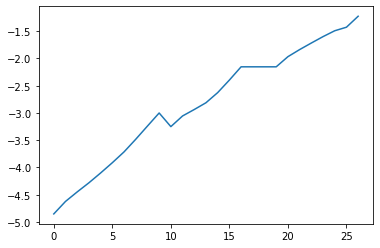

In [ ]:
import matplotlib.pyplot as plt

episodes = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 6
agent = HIRO(n_observations, n_actions).to(device)
load_model(agent, f"hiro_freeze_{i}")
episodes = get_intrinsic_reward(agent)

print("Freeze")

eps = np.array([np.array(l) for l in episodes])
#eps = np.mean(eps, 0)

plt.plot(eps[3])
plt.show()

95.64999999999947
Standard


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


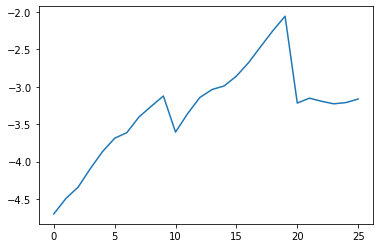

In [ ]:
episodes = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 3
agent = HIRO(n_observations, n_actions).to(device)
load_model(agent, f"hiro_{i}", "point_maze_time")
episodes = get_intrinsic_reward(agent)

print("Standard")

eps = np.array([np.array(l) for l in episodes])
#eps = np.mean(eps, 0)

plt.plot(eps[2])
plt.show()